# Noise's Impact on Performance of Speech Recognition mechanism

In [1]:
# import packages
import soundfile as sf  
import random
import speech_recognition as sr
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as mpl
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from IPython import display

**Project Description**:
    Through analyzing a selected passage of *the Gettysburg Address*, this project models how the addition of noise impact the performance of Google Speech Recognition API and analyzes further into some specifics, including whether the speech recognition API produces varied output when given the same input and on keeping track of data to find out the most noise-resistant word. 
    
**Project Breakdown**:
1. Collection of Data and Test (noise vs. performance of speech recognition mechanism) 
2. Visualization of Noise vs. Performance of Speech Recognition
3. Test into the Variance of Speech recognition mechanism


## Test Environment SetUp



**Audio Source** I decided to use an audio of passage selected from *The Gettysburg Address* by Abraham Lincoln, as attached below:  

In [2]:
display.Audio('data/gettysburg.wav') #display audio of gettyburg speech 

**Setup Reference Text: STATS**
By processing reference text, I found the following information about the (original) reference text of gettysburg speech: 

    - total words count: 52
    - total unique words count: 43

In [3]:
#set original to the reference text from gettysburg speech (ref gettyspeech)
original= 'Four score and seven years ago our fathers brought forth on this continent, a new nation, \
conceived in Liberty, and dedicated to the proposition that all men are created equal. Now we are\
engaged in a great civil war, testing whether that nation, or any nation so conceived and so dedicated,\
can long endure.'
#split original into list of words with no comma or period
lst_words =original.split(' ')
for i in range(len(lst_words)):
    lst_words[i]=lst_words[i].strip(',').strip('.')
    
#print the first five words in the ref gettyspeech
lst_words[:5]

['Four', 'score', 'and', 'seven', 'years']

In [4]:
# Words in total in ref gettyspeech (52)
len(lst_words) 
# Unique Words in total in ref gettyspeech (43)
uniq_lst = set(lst_words)
unique_orig = len(set(lst_words))

**Setup speech recognition on processing audio file**

I setup the Google Speech Recognition API to read the gettysburg.wav audio file and was able to obtain the file's audio data *(in array)* and sampling rate *(int)* 

In [5]:
recognizer = sr.Recognizer() #create a speech recognizer

In [6]:
#read gettysburg.wav file 
gettytext = read("data/gettysburg.wav") 
#get the array of gettysburg actual arrayed audio data -audiodata
audioData = gettytext[1] 
#get sampling rate of audiodata (22050)
samplingRate = gettytext[0] 

## Collection of data (Noise vs. Performance of speech recognition mechanism)

Ten trials of tests are ran below to model how the performance of speech recognition mechanism varies as noise increases. In each trial, a measure of performance of speech recognition on the original audio file is done first to set a control for the preceding measures of performance on audio file with increasing noise. Each measure of performance is done by counting how many unique words the speech recognition mechanism was able to capture correctly compared to the total unique words that the original reference(text) file contains

In [7]:
'''the function below runs one time the simulation of testing and showing a graph of how increased noise influences accuracy
of speech recognition tool 
'''
def onetime(track_words, randNoise ):
    #initialize the list data_noise (data_correct) to collect 
    #the independent variable - noise data (dependent variable - correct data)
    data_noise = [] 
    data_correct = []
    
    
    #set up dictionary that keeps track of frequency of unique 
    #words recognized by speech recognition mechanism 
    track_words = track_words 
    

    # speech recognition performed on gettysburg.wav 
    with sr.AudioFile("data/gettysburg.wav") as source:
        audio_data = recognizer.record(source)  
        recognizer.adjust_for_ambient_noise(source)
    
    #if we do not want random noisebase, we seed the array 
    #we generate seeded array (same among trials) or varied base noise arrays
    if randNoise== False:
        np.random.seed(30)
    NoiseBase = np.random.randn(len(audioData))
    print('Noise Base: '+ str(NoiseBase))
    
    
    #simulate different strength of noises and how it influences accuracy- quantified by how many numbers of words 
    #the speech recognition tool got correctly in comparison to the original transcription file 
    for i in range(0,9000,500):
        
        # initialize a count for recognized text
        num_recognized = 0 
        
        
        # simulate different strength of audio noise by multiplying increasing i which increases to noise's volume
        #generate a random noise audio that's the same length as gettysburg speech 
        audioNoise = NoiseBase*i 
        
        
        #print the max volume of audio data itself
        print('max volume audio: '+str(np.max(np.abs(audioData)))) 
        #print the max volume of audio noise itself
        print('max volume noise: '+str(np.max(np.abs(audioNoise)))) 
        
        
        #overlap audio data and audio noise, store the audio with noise as a wav file, 
        #and write and save the new gettysburg speech file that is accompanied by 
        #certain strength of noise from background 
        audioWithNoise = audioData +audioNoise  
        scaled = np.int16(audioWithNoise/np.max(np.abs(audioWithNoise)) * 32767)
        write('data/output_with_noise1.wav', samplingRate, scaled)

        
        # when noise does not dominate over the gettysburg speech itself, 
        #try transcripting the processed/noised audio
        try:
            
            with sr.AudioFile('data/output_with_noise1.wav') as source:
                audio_data = recognizer.record(source)  
                recognizer.adjust_for_ambient_noise(source)
                text =recognizer.recognize_google(audio_data) 
                print('Output: '+ text +'\n' )
               
            
            # save a list of unique set of words that could be
            #identified from processed/noised gettysburg speech 
            lst_text = set(text.split(' '))
            
            
            '''
            loop through the recognized words to count
            how many there are that matches with the original file
            and keep track of what unique words are recognized by 
            the speech recognition mechanism 
            '''
            
            for word in lst_text: 
                if word in uniq_lst:
                    num_recognized+=1
                if word not in track_words: 
                    track_words[word] = 1
                else:
                    track_words[word] += 1
        
        # when noise does dominate over the gettysburg speech itself,
        #set number of words recognized to 0 to avoid error 
        except sr.UnknownValueError:
            num_recognized = 0
            print('Output: N/A \n' )
        
        
        #append used audio noise / the certain strength of 
        #noise used to data_noise
        data_noise.append(np.max(np.abs(audioNoise)))
        
        #append the number of unique words correctly transcripted depending on 
        #certain used audio noise / certain strength of noise used to data_correct
        data_correct.append(num_recognized)
        
    #print final array of data noise collected during this trial 
    print(np.array(data_noise)) 
    #print final array of collected data for words correctly transcripted during this trial 
    print(np.array(data_correct)) 
    #plot data noise vs data num of words correctly identified - speech recognition capability 
    mpl.plot(np.array(data_noise),np.array(data_correct))
    return track_words #new dict

In [8]:
'''The function below simulates specified num_trials of simulation of testing and showing a graph of how increased
noise influences accuracy of speech recognition tool '''
def simulate_noisevcorrect(num_trials, randNoise=True):
    new_dict = dict()
    for i in range(num_trials):
        print('Trial: '+str(i+1))
        new_dict = onetime(new_dict, randNoise)
        new_dict = dict(sorted(new_dict.items(), key=lambda item: item[1]))
        mpl.title('Noise vs Performance of Speech Recognition')
        mpl.ylabel('Accuracy (unique correct/total unique)')
        mpl.xlabel('Noise')
        print('\n\n')
    return new_dict
        

Trial: 1
Noise Base: [ 0.59218801 -0.22183622 -0.76156321 ... -0.09189117  0.23011314
 -1.4450896 ]
max volume audio: 11643
max volume noise: 0.0
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in liberty and dedicated to the proposition that all men are created equal now we are engaged in a great civil war testing whether that Nation or any Nation so conceived and so dedicated can long endure

max volume audio: 11643
max volume noise: 2660.102942275493
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in liberty and dedicated to the proposition that all men are created equal now we are engaged in a great civil war testing whether that Nation or any Nation so conceived and so dedicated can long endure

max volume audio: 11643
max volume noise: 5320.205884550986
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in liber

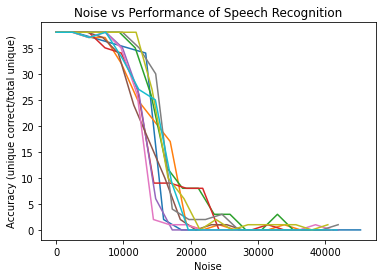

In [9]:
#simulate ten trials of displaying relationship of strength of noise vs speech recognition tool capability/accuracy
freq_words= simulate_noisevcorrect(10, randNoise= True)

In [25]:
print(freq_words)

{'longing': 1, '170': 1, '/': 1, 'Alcott': 1, 'East': 1, '1': 1, '175': 1, 'Orlando': 1, 'Johnny': 1, 'has': 1, 'one': 1, '403': 1, '44w': 1, 'W': 1, 'Godfather': 1, 'Amino': 1, 'major': 1, 'completely': 1, '400m': 1, 'emo': 1, '1408': 1, 'review': 1, 'future': 1, 'as': 1, 'unlock': 1, 'after': 1, 'Barack': 1, 'Obama': 1, 'working': 1, 'Chatsworth': 1, 'Olivia': 1, 'Andrews': 1, 'David': 1, 'video': 1, 'meaning': 1, 'Newman.': 1, 'dr.': 1, '2017.': 1, 'alcohol': 1, '420': 1, 'up': 1, 'here': 1, 'proposition.': 1, 'Now': 1, 'divorce': 1, 'LeBron': 1, 'James': 1, 'Thunder': 1, 'All': 1, 'Hyundai': 1, 'welfare': 1, 'Court': 1, 'number.': 1, 'longer': 1, 'oil': 1, 'vegetable': 1, '4:00': 1, 'definitely': 1, 'open': 1, '4:30': 1, '4438': 1, '474': 1, '4449': 1, 'Father': 1, 'destination': 1, 'got': 1, 'Some': 1, 'nation.': 1, 'continent.': 1, 'timer.': 1, 'minute': 1, 'crossword': 1, 'hungry': 1, 'Longview': 1, 'almond': 1, 'reversible': 1, 'almost': 1, 'week': 1, 'Grant': 1, '448': 1, 'Jac

In [28]:
most_freq= list(freq_words.keys())[-1]
num_most_freq = 0
for word in freq_words:
    if most_freq.strip('s') in word.lower():
        num_most_freq+= freq_words[word]
        
(most_freq,num_most_freq)

('fathers', 111)

## Conclusion- Visualization

From the visualization above, it's suggested that as noise increases and is layered onto the original audio file, the performance of speech recognition mechanism is impacted negatively or, in other words, it is changed in a way that a lower accuracy is obtained. 

It can also be observed from the dictionary (most_freq) that I set up for counting frequency of unique words recognized by speech recognition on the selected gettysburg passage that the most noise-resistant word is 'father', which were counted for 111 times. 


## Test Existence of Variation 

By setting a seed to produce the same array of noise base (NoiseBase), we can test and understand more about how the google speech recognition mechanism works or, specifically, on whether variation occurs among trials when we use the exactly same different noise inputs to model two trials of how performance of speech recognition mechanism changes as noise increases. 

Trial: 1
Noise Base: [-1.26405266  1.52790535 -0.97071094 ...  0.85130204  0.56328672
  1.73439333]
max volume audio: 11643
max volume noise: 0.0
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in liberty and dedicated to the proposition that all men are created equal now we are engaged in a great civil war testing whether that Nation or any Nation so conceived and so dedicated can long endure

max volume audio: 11643
max volume noise: 2350.1355867052257
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in liberty and dedicated to the proposition that all men are created equal now we are engaged in a great civil war testing whether that Nation or any Nation so conceived and so dedicated can long endure

max volume audio: 11643
max volume noise: 4700.271173410451
Output: four score and seven years ago our fathers brought forth on this continent a new nation conceived in libe

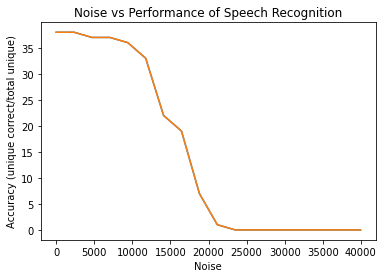

In [11]:
var_test = simulate_noisevcorrect(2, randNoise= False)

## Additional Discussion-  Existence of Variance 

From the result above, we may conclude that when given the same base noise array among different trials, the models produced to describe performances of speech recognition machanism in respect to increasing noise do not show inconsistency, which allows us to conclude that the google API use techniques that ensure consistency in speech recognition.